In [94]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q
from optimize import Run_eval_test,optimize_parallel_new 
from utils import * 
import copy

In [95]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

def compute_H(k,x):
    return H(k[0],x[:,0])*H(k[1],x[:,1])

In [96]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,K_max,S_max,N_test,x0):
    """
    function to perform 1-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed)
    S_test = X_test[0,:]
    V_test = X_test[1,:]
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    num_basis_funcs = K_max+1
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((num_basis_funcs,N_test), dtype = float)
    for k in range(len(poly_vals)):
        poly_vals[k,:] = H(k,Noise[:,0])
    #initialize function
    f_vals_vanilla = X_test[:,0]
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_1 = np.zeros((lag,N_test),dtype=float)
    bar_a_2 = np.zeros_like(bar_a_1)
    print(X_test.shape)
    for i in range(lag):
        #second-order coefficients
        bar_a_2[i,1:] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(X_test[:-1]))**2
        bar_a_2[i,0] = coefs_poly_regr[i,2]*np.sqrt(2)*gamma*(sigma(x0))**2
        #first-order coefficients
        bar_a_1[i,1:] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(X_test[:-1]) +\
                coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(X_test[:-1])*(S_test[:-1]+gamma*b(S_test[:-1]))
        bar_a_1[i,0] = coefs_poly_regr[i,1]*np.sqrt(gamma)*sigma(x0) +\
                        coefs_poly_regr[i,2]*2*np.sqrt(gamma)*sigma(x0)*(x0[0]+gamma*b(x0[0]))
    bar_a_1 = bar_a_1*poly_vals[1,:]
    bar_a_2 = bar_a_2*poly_vals[2,:]
    #compute martingale sums
    M_n_1 = 0.0
    M_n_2 = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_1 += bar_a_1[r,l]
            M_n_2 += bar_a_2[r,l]
    print("M_n_2: ",M_n_2)
    print("M_n_1: ",M_n_1)
    return np.mean(f_vals_vanilla),np.mean(f_vals_vanilla)-M_n_1/N_test,np.mean(f_vals_vanilla)-M_n_1/N_test-M_n_2/N_test
#
#
#

In [97]:
def approx_q(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    #print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        #print("variance: ",np.var(y_all))
        #print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        #print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [98]:
kappa = 1.2
theta = 0.04
#correlation coefficient in Heston model
rho = 0.5
#interest rate
r = 0.05
sig = 0.1

def b(S_t):
    """
    b function in the diffusion
    """
    return gamma*r*S_t

def sigma(X_t):
    """
    b function in the diffusion
    """
    if len(X_t.shape) == 1:
        return np.sqrt(X_t[1])*X_t[0]
    else:
        return np.sqrt(X_t[:,1])*X_t[:,0]

def sample_discretized_diffusion(S_t,V_t,gamma_t):
    """
    args:   S_t - asset price;
            V_t - volatility value;
            gamma_t - step size;
            d - dimension;
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn(2)
    S = (1+r*gamma_t)*S_t + np.sqrt(gamma_t*V_t)*S_t*xi[0]
    xi_new = rho*xi[0] + np.sqrt(1-rho**2)*xi[1]  
    V = (1-gamma_t*kappa)*V_t + gamma_t*(kappa*theta-1./4*(sig**2)) + np.sqrt(gamma_t*V_t)*sig*xi_new + 0.25*gamma_t*(sig**2)*(xi_new**2 + (xi_new**2)/(1-gamma_t*kappa) - 1)
    #V = np.abs(V_t + gamma_t*kappa*(theta-V_t) + np.sqrt(gamma_t*V_t)*(rho*xi[0] + np.sqrt(1-rho**2)*xi[1]))
    return np.array([S,V]),np.array([xi[0],xi_new])

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros((n,d),dtype = float)
    noise_all = np.zeros((n,d),dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0[0],x0[1],gamma)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1][0],x_all[i-1][1],gamma)
    return x_all,noise_all

def run_monte_carlo(x,f_type):
    if f_type == "quadratic":
        f_vals = x**2
    else:
        raise "not implemented error"
    return np.mean(f_vals,axis=1)

In [99]:
n = 5*10**3 #sample size
gamma = 1./252 # Step size
n_traj = 1
d = 2
n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "linear"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 500 #maximal lag order
N_test = 5*10**3

Sample discretized diffusion

In [100]:
x0 = np.array([100.0,0.04],dtype = float)
r_seed = 1812
X_train, noise_train = generate_traj(x0,n,gamma,r_seed)
print(X_train[:,1])
#set target function
Y_train = X_train[:,0]
X_train = X_train[:,0].reshape((1,-1,1))
Y_train = Y_train.reshape((1,-1,1))

[0.03943628 0.04029549 0.0387295  ... 0.03702231 0.03802052 0.03744887]


### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [101]:
#polynomial coefficients
coefs_poly = approx_q(X_train,Y_train,n_traj,lag,S_max)
print(coefs_poly.shape)
print(coefs_poly)
regr_vals = np.zeros((lag,X_train.shape[1]),dtype=float)
for i in range(len(regr_vals)):
    for j in range(S_max+1):
        regr_vals[i,:] += coefs_poly[i,j]*X_train[0,:,0]**j

(500, 3)
[[ 2.51976827e-12  1.00000000e+00  2.22044605e-16]
 [-1.74690792e-03  1.00303828e+00 -4.12112478e-05]
 [ 9.37565917e-03  1.00583011e+00 -8.15087875e-05]
 ...
 [ 2.38263428e+01  1.17641054e+00 -6.74060038e-03]
 [ 2.41315210e+01  1.16826610e+00 -6.68754217e-03]
 [ 2.44776007e+01  1.15917963e+00 -6.62937455e-03]]


Test our regressors

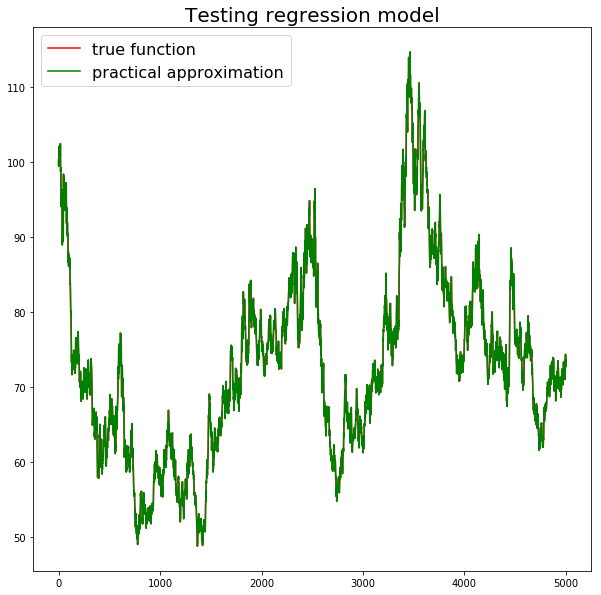

In [102]:
cur_lag = 0
N_pts = 30000
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()

In [103]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(coefs_poly,gamma,test_seed+i,lag,K_max,S_max,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()

(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
M_n_2:  870.5101022209777
M_n_1:  7739.653182972345
M_n_2:  355.1408046338063
M_n_2:  757.8610492862439
M_n_1:  -10122.059364516086
M_n_2:  -2380.4841318688455
M_n_1:  2016.1051333787648
M_n_1:  -7723.847534775644
(5000, 2)
(5000, 2)
(5000, 2)
(5000, 2)
M_n_2:  2506.6015886051728
M_n_1:  -8628.561320082406
M_n_2:  -1120.286487443521
M_n_2:  996.3489988952028
M_n_2:  -11054.128926520307
M_n_1:  -12407.184546030447
M_n_1:  -4958.153764007508
(5000, 2)
M_n_1:  13319.660449551653
(5000, 2)
(5000, 2)
(5000, 2)
M_n_2:  5955.0349309621615
M_n_1:  -4796.644821028921
M_n_2:  4711.481404871803
M_n_2:  -2939.442438781305
M_n_1:  42337.63981820625
M_n_1:  22151.975283917538
M_n_2:  -4557.447488048306
(5000, 2)
M_n_1:  -11932.756846891252
(5000, 2)
(5000, 2)
(5000, 2)
M_n_2:  12638.27017809173
M_n_1:  1208.3848320062993
M_n_2:  -7220.920647114563
M_n_2:  -172.06115846106798
M_n_1:  -7628.418985478062
M_n_1:  -2937.059961744439
M_n_2:  400.5440751142105
M_n_1:

In [84]:
res_new = np.asarray(res)
print(res_new.shape)

(100, 3)


### Comparison plots

In [85]:
title = ""
labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1','Euler scheme \nwith MDCV-2']
#labels = ['Vanilla\n ULA', 'ULA \nwith MDCV-1', 'ULA \nwith MDCV-2']

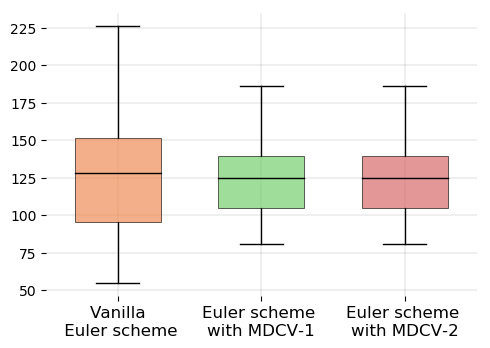

In [86]:
data = [res_new[:,0],res_new[:,1],res_new[:,2]] 
boxplot_ind(data, title, labels,path="./Heston_price.pdf")